In [2]:
#Importar las librerías por utilizar
import os
import numpy as np
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import math
from skimage import io
from skimage.filters import threshold_otsu
from skimage.transform import resize, probabilistic_hough_line,hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from skimage.color import rgb2gray,rgb2hsv,hsv2rgb
from skimage.draw import circle_perimeter
from skimage import exposure
from skimage.morphology import disk
from skimage.morphology import (erosion, dilation, opening, closing)
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops, regionprops_table
from skimage import data, img_as_float
from skimage import exposure
from scipy import ndimage
import pandas as pd

In [3]:
#Obtener la direccion de las imagenes
path = os.getcwd()


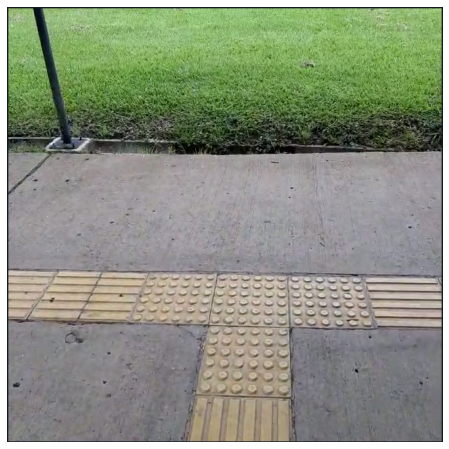

tamaño: (643, 644, 4)


In [52]:
#Imagen original
file_path = os.path.join(path , 'IMG_08.png')
img_org = io.imread(file_path)
shape = img_org.shape

plt.figure(figsize = (9,8))
plt.imshow(img_org)
plt.axis('off')
plt.show()
print('tamaño: ' + str(img_org.shape))

In [53]:
# Escala y Recorta la imagen a 360x320
def edit_image(image):
    y,x = image.shape[:2]
    y_div = y//2
    x_div = x
    cropped = image[y_div:y,0:x_div]
    resized = resize(cropped,(360,320),preserve_range=True).astype(int)
    return resized

resized1 = edit_image(img_org)
"""
plt.figure(figsize = (9,12))
plt.imshow(resized1)
plt.axis('off')
plt.show()
print('tamaño: ' + str(resized1.shape))
"""

"\nplt.figure(figsize = (9,12))\nplt.imshow(resized1)\nplt.axis('off')\nplt.show()\nprint('tamaño: ' + str(resized1.shape))\n"

In [54]:
# Convierte la imagen RGBA a RGB y HSV
def rgba2rgb( rgba, background=(255,255,255) ):
    row, col, ch = rgba.shape
    if ch == 3:
        return rgba
    assert ch == 4, 'RGBA image has 4 channels.'
    rgb = np.zeros( (row, col, 3), dtype='float32' )
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]
    a = np.asarray( a, dtype='float32' ) / 255.0
    R, G, B = background
    rgb[:,:,0] = r * a + (1.0 - a) * R
    rgb[:,:,1] = g * a + (1.0 - a) * G
    rgb[:,:,2] = b * a + (1.0 - a) * B
    return np.asarray( rgb, dtype='uint8' )

img_org_RGB =rgba2rgb(resized1)
img_org_HSV =rgb2hsv(img_org_RGB)


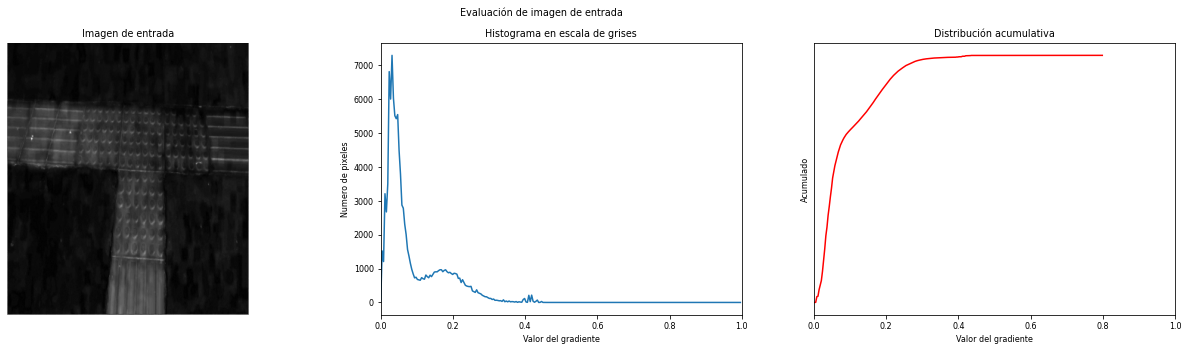

In [55]:
# Evaluación de Saturacion
# https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html
fig_eval, axs = plt.subplots(1,3,figsize=(22,5))
fig_eval.suptitle('Evaluación de imagen de entrada')

axs[0].set_title("Imagen de entrada")
axs[0].imshow(img_org_HSV[:,:,1],cmap=plt.cm.gray)
axs[0].set_axis_off()

# create the histogram
histogram, bin_edges = np.histogram(img_org_HSV[:,:,1], bins=256, range=(0, 1))
# Display histogram
axs[1].set_title("Histograma en escala de grises")
axs[1].set_xlabel("Valor del gradiente")
axs[1].set_ylabel("Numero de pixeles")
axs[1].set_xlim([0.0, 1])
axs[1].plot(bin_edges[0:-1], histogram)
# Display cumulative distribution
img_cdf, bins = exposure.cumulative_distribution(img_org_HSV[:,:,1], 256)
axs[2].set_title("Distribución acumulativa")
axs[2].set_xlabel("Valor del gradiente")
axs[2].set_ylabel("Acumulado")
axs[2].set_xlim([0.0, 1])
axs[2].plot(bins, img_cdf, 'r')
axs[2].set_yticks([])

plt.show()

C:\Users\carlo\AppData\Local\Temp\ipykernel_1240\2542101163.py:48: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  axes = np.zeros((2, 4), dtype=np.object)


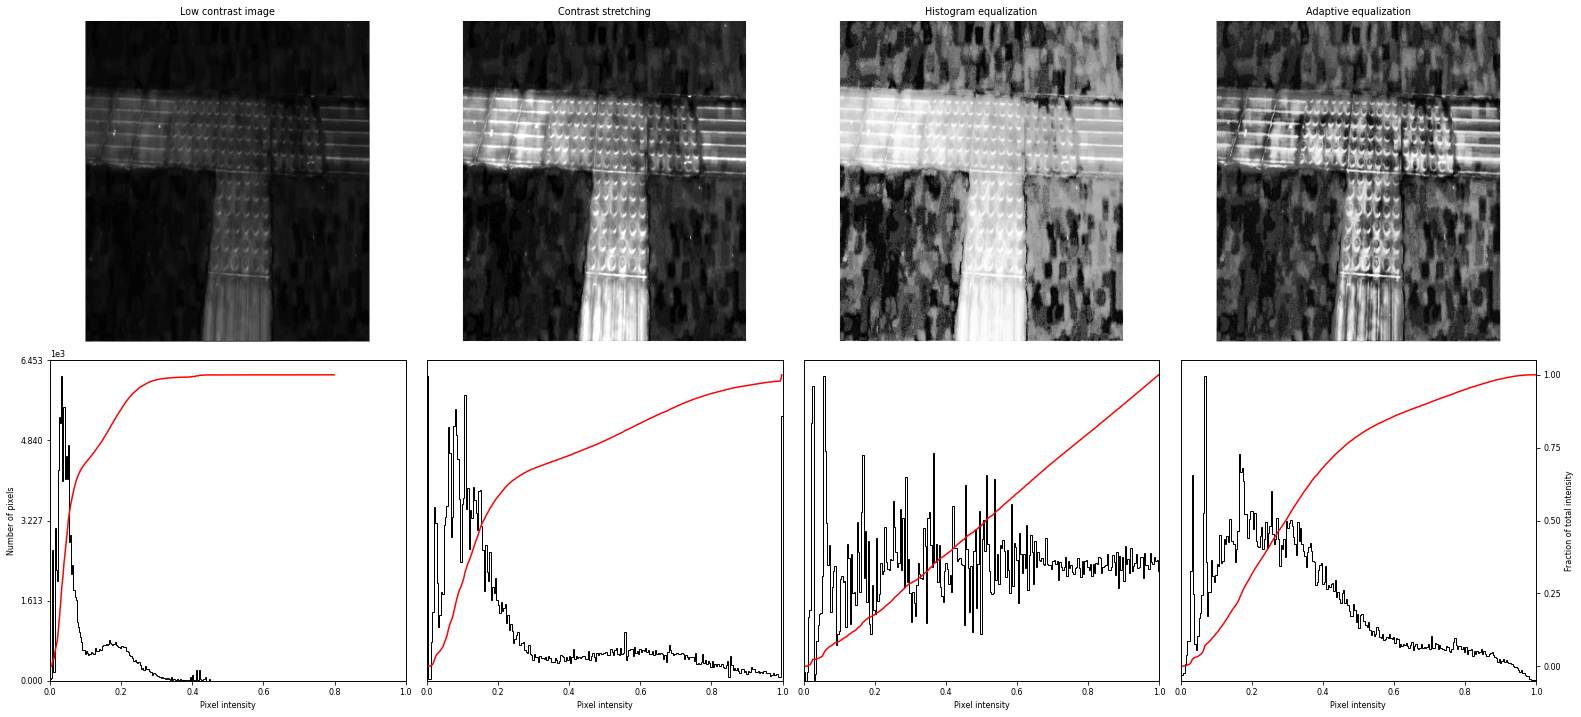

In [56]:
# Mejora de Saturacion
# https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html
matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img_sat = img_org_HSV[:,:,1]

# Contrast stretching
p2, p98 = np.percentile(img_sat, (2, 98))
img_rescale_sat = exposure.rescale_intensity(img_sat, in_range=(p2, p98))

# Equalization
img_eq_sat = exposure.equalize_hist(img_sat)

# Adaptive Equalization
img_adapteq_sat = exposure.equalize_adapthist(img_sat, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(22, 10))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_sat, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale_sat, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq_sat, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq_sat, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

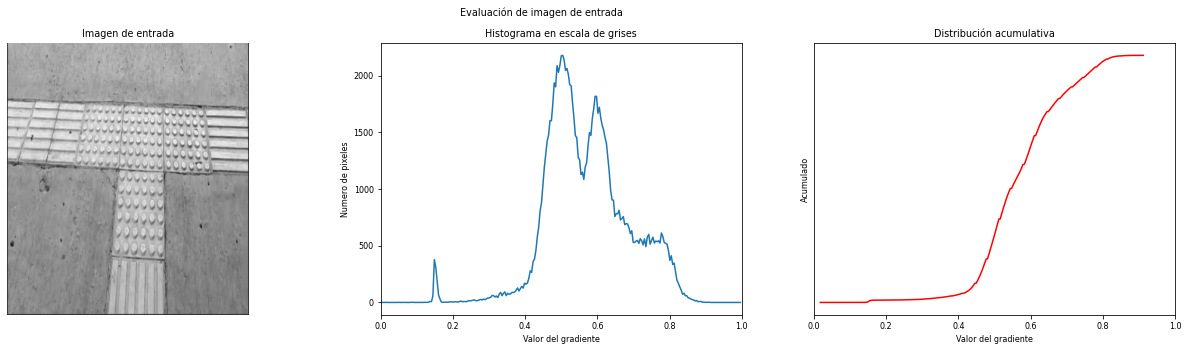

In [57]:
# Evaluación de Contraste
# https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html
fig_eval, axs = plt.subplots(1,3,figsize=(22,5))
fig_eval.suptitle('Evaluación de imagen de entrada')

axs[0].set_title("Imagen de entrada")
axs[0].imshow(img_org_HSV[:,:,2],cmap=plt.cm.gray)
axs[0].set_axis_off()

# create the histogram
histogram, bin_edges = np.histogram(img_org_HSV[:,:,2], bins=256, range=(0, 1))
# Display histogram
axs[1].set_title("Histograma en escala de grises")
axs[1].set_xlabel("Valor del gradiente")
axs[1].set_ylabel("Numero de pixeles")
axs[1].set_xlim([0.0, 1])
axs[1].plot(bin_edges[0:-1], histogram)
# Display cumulative distribution
img_cdf, bins = exposure.cumulative_distribution(img_org_HSV[:,:,2], 256)
axs[2].set_title("Distribución acumulativa")
axs[2].set_xlabel("Valor del gradiente")
axs[2].set_ylabel("Acumulado")
axs[2].set_xlim([0.0, 1])
axs[2].plot(bins, img_cdf, 'r')
axs[2].set_yticks([])

plt.show()

C:\Users\carlo\AppData\Local\Temp\ipykernel_1240\3659530571.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  axes = np.zeros((2, 4), dtype=np.object)


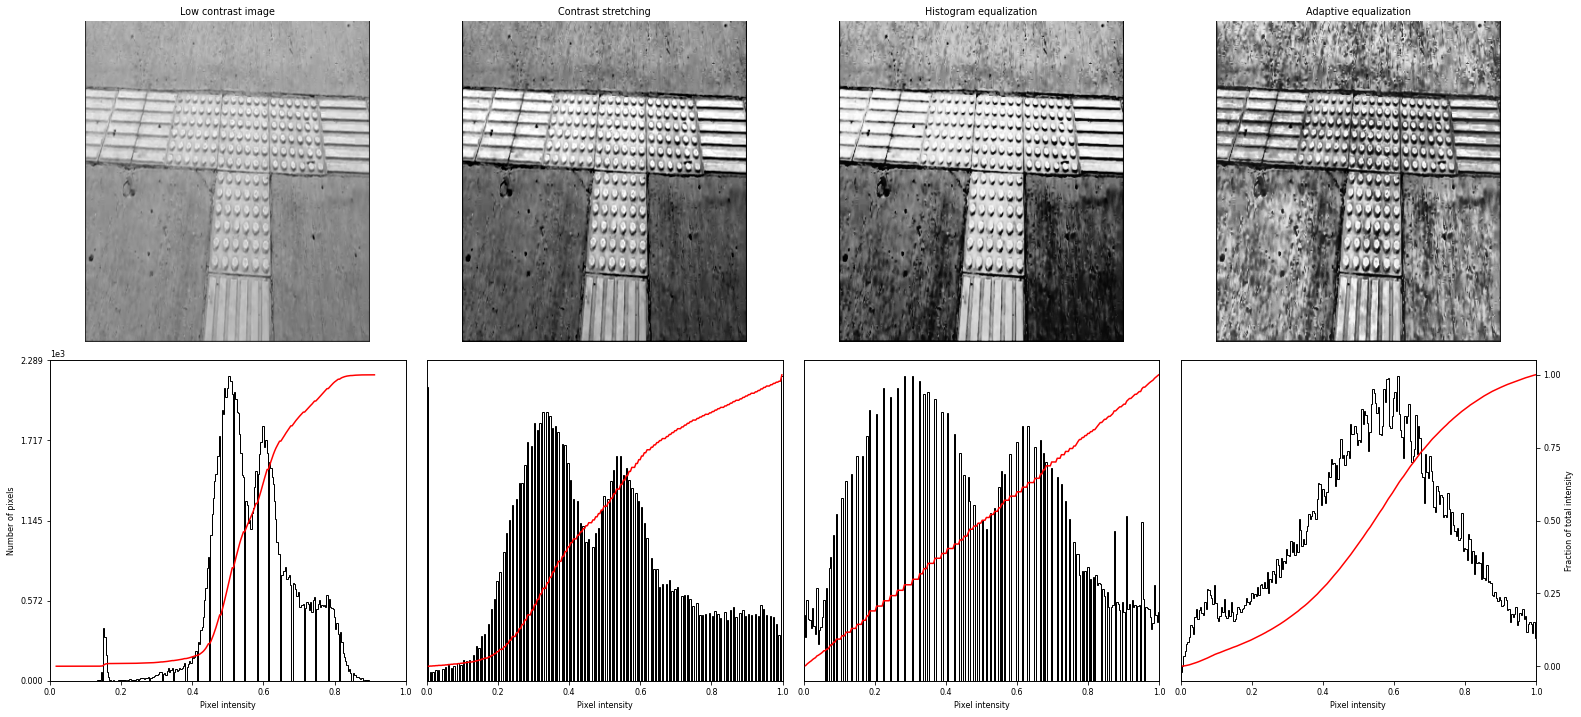

In [58]:
# Mejora de Contraste
# https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html
matplotlib.rcParams['font.size'] = 8

# Load an example image
img_con = img_org_HSV[:,:,2]

# Contrast stretching
p2, p98 = np.percentile(img_con, (2, 98))
img_rescale_con = exposure.rescale_intensity(img_con, in_range=(p2, p98))

# Equalization
img_eq_con = exposure.equalize_hist(img_con)

# Adaptive Equalization
img_adapteq_con = exposure.equalize_adapthist(img_con, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(22, 10))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_con, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale_con, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq_con, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq_con, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

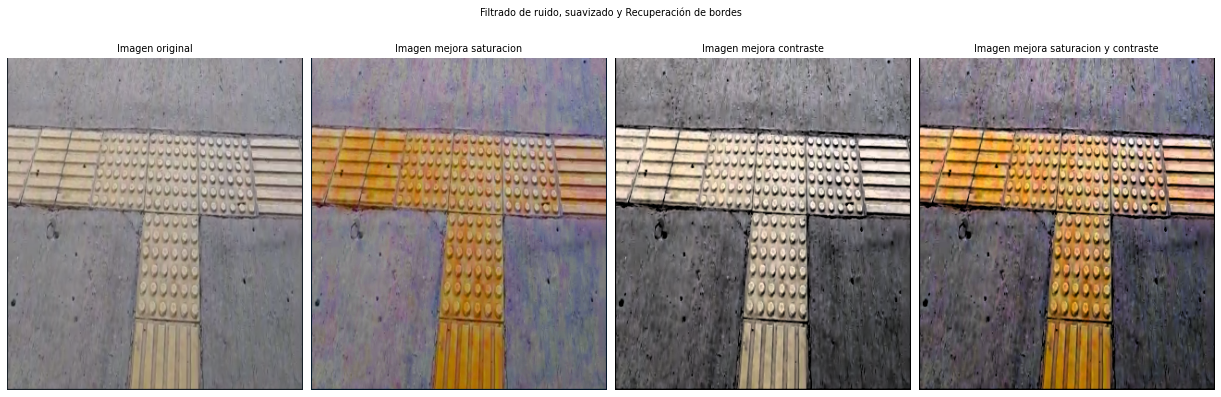

In [59]:
img_org_HSV = rgb2hsv(img_org_RGB)
img_eq_1 = img_org_HSV
img_eq_1[:,:,1] = img_rescale_sat
img_org_HSV = rgb2hsv(img_org_RGB)

img_eq_2 = img_org_HSV
img_eq_2[:,:,2] = img_rescale_con
img_org_HSV = rgb2hsv(img_org_RGB)

img_eq_3 = img_org_HSV
img_eq_3[:,:,1] = img_rescale_sat
img_eq_3[:,:,2] = img_rescale_con
img_org_HSV = rgb2hsv(img_org_RGB)

fig1, axs = plt.subplots(1,4,figsize=(17,6))
fig1.suptitle('Filtrado de ruido, suavizado y Recuperación de bordes')

axs[0].set_title("Imagen original")
axs[0].imshow(hsv2rgb(img_org_HSV))
axs[0].set_axis_off()


axs[1].set_title("Imagen mejora saturacion")
axs[1].imshow(hsv2rgb(img_eq_1))
axs[1].set_axis_off()

axs[2].set_title("Imagen mejora contraste")
axs[2].imshow(hsv2rgb(img_eq_2))
axs[2].set_axis_off()

axs[3].set_title("Imagen mejora saturacion y contraste")
axs[3].imshow(hsv2rgb(img_eq_3))
axs[3].set_axis_off()

plt.tight_layout()
plt.show()

In [60]:
#PARAMETROS

#numero de colores incluyendo el fondo
N_COLORS = 5

In [66]:
#Quantificacion 4 colores
#https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html#sphx-glr-auto-examples-cluster-plot-color-quantization-py

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(w, h, -1)

def img_to_5_colors(img):
    # Copia de la imagen por cuantificar
    img_5_colors = img

    # Convert to floats instead of the default 8 bits integer coding. Dividing by
    # 255 is important so that plt.imshow behaves works well on float data (need to
    # be in the range [0-1])
    img_5_colors = np.array(img_5_colors, dtype=np.float64)

    # Load Image and transform to a 2D numpy array.
    w, h, d = tuple(img_5_colors.shape)
    assert d == 3
    image_array = np.reshape(img_5_colors, (w * h, d))
    image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
    kmeans = KMeans(n_clusters=N_COLORS, random_state=0).fit(image_array_sample)
    labels = kmeans.predict(image_array)
    colores = kmeans.cluster_centers_
    #coloresh = rgb2hsv(colores)[:,0]
    #coloress = rgb2hsv(colores)[:,1]
    #coloresv = rgb2hsv(colores)[:,2]
    coloresh = colores[:,0]
    coloress = colores[:,1]
    coloresv = colores[:,2]
    #print(coloresh)
    #print(coloress)
    #print(coloresv)
    for i in range(N_COLORS):
        if not (0.1 < coloresh[i] < 0.19 and coloress[i] > 0.3 and coloresv[i] > 0.15):
            colores[i] = [0, 0, 0]
        new_img = recreate_image(colores, labels, w, h)
    #plt.imshow(new_img)
    new_img = rgb2hsv(new_img)[:,:,2]
    new_img = new_img > threshold_otsu(new_img)
    footprint = disk(10)
    new_img = closing(new_img,footprint)
    return new_img

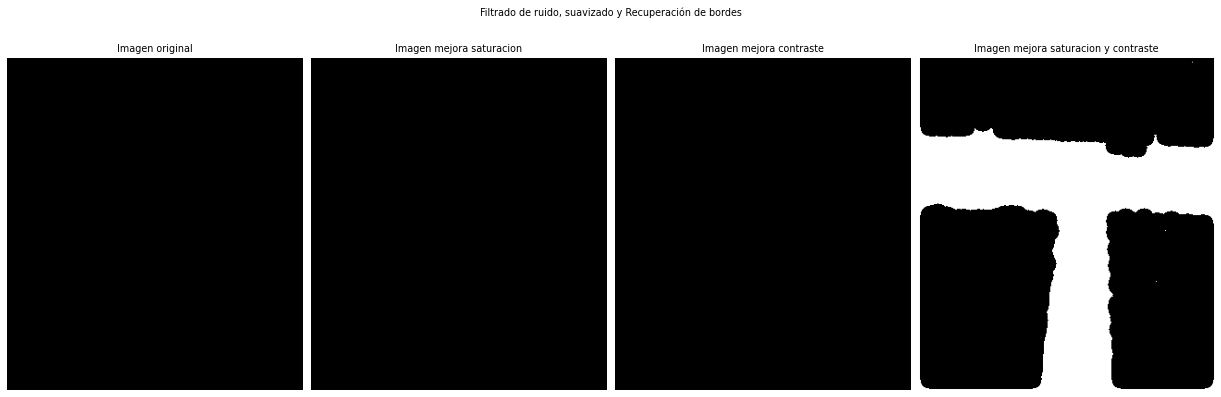

In [67]:

quant1 = img_to_5_colors(img_org_HSV)
quant2 = img_to_5_colors(img_eq_1)
quant3 = img_to_5_colors(img_eq_2)
quant4 = img_to_5_colors(img_eq_3)

fig1, axs = plt.subplots(1,4,figsize=(17,6))
fig1.suptitle('Filtrado de ruido, suavizado y Recuperación de bordes')

axs[0].set_title("Imagen original")
axs[0].imshow(quant1,cmap='gray')
axs[0].set_axis_off()


axs[1].set_title("Imagen mejora saturacion")
axs[1].imshow(quant2,cmap='gray')
axs[1].set_axis_off()

axs[2].set_title("Imagen mejora contraste")
axs[2].imshow(quant3,cmap='gray')
axs[2].set_axis_off()

axs[3].set_title("Imagen mejora saturacion y contraste")
axs[3].imshow(quant4,cmap='gray')
axs[3].set_axis_off()

plt.tight_layout()
plt.show()

In [63]:
def preproc(img):
    resized = edit_image(img)
    img_RGB =rgba2rgb(resized)
    img_HSV =rgb2hsv(img_RGB)
    img_eq = img_HSV
    p2s, p98s = np.percentile(img_HSV[:,:,1], (2, 98))
    img_rescale_sat = exposure.rescale_intensity(img_HSV[:,:,1], in_range=(p2s, p98s))
    p2c, p98c = np.percentile(img_HSV[:,:,2], (2, 98))
    img_rescale_con = exposure.rescale_intensity(img_HSV[:,:,2], in_range=(p2c, p98c))
    img_eq[:,:,1] = img_rescale_sat
    img_eq[:,:,2] = img_rescale_con
    plt.imshow(hsv2rgb(img_eq))
    plt.show()    
    quant = img_to_5_colors(img_HSV)
    return quant

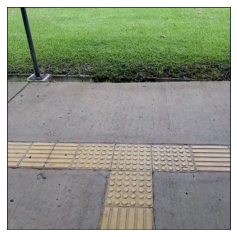

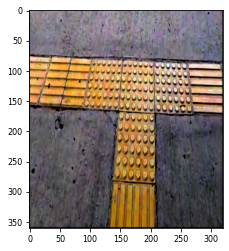

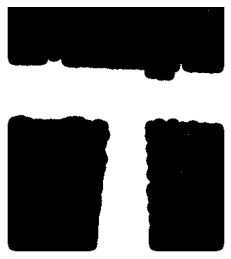

In [68]:
file_path = os.path.join(path , 'IMG_08.png')
img_org = io.imread(file_path)
plt.figure(figsize = (4,4.5))
plt.imshow(img_org, cmap='gray')
plt.axis('off')
plt.show()
quant = preproc(img_org)
plt.figure(figsize = (4,4.5))
plt.imshow(quant, cmap='gray')
plt.axis('off')
plt.show()

4


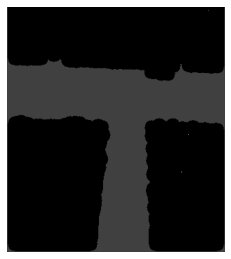

In [71]:
segmented, num_segments = label(quant,return_num = True,connectivity= None)
print(num_segments)
plt.figure(figsize = (4,4.5))
plt.imshow(segmented, cmap='gray')
plt.axis('off')
plt.show()

props = regionprops(segmented)

In [104]:
for i in range(1,num_segments):
    region = segmented == i

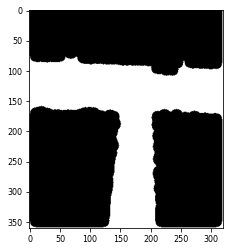

In [106]:
for prop in props:
    if prop.area > 10000 and prop.label != 0:
        region_label = prop.label
        region = (segmented == region_label)*1
plt.imshow(region, cmap = "gray")
plt.show()

In [110]:
r_border = region[:,300:320]
l_border = region[:,0:20]
u_border = region[40:60,:] # indica posible interseccion cruz o T
ur_safe_corner = region[0:40,:]
r_path = np.sum(r_border) > 800 #existe camino der
l_path = np.sum(l_border) > 800 #existe camino izq
u_path = np.sum(u_border) > 500 #posible camino recto

In [114]:
#Intersecciones
cruz = l_path and r_path and u_path
Te = l_path and r_path and (not u_path)
i_l = l_path and (not r_path) and u_path
i_r = (not l_path) and r_path and u_path
codo_l = l_path and (not r_path) and (not u_path)
codo_r = (not l_path) and r_path and (not u_path)

In [115]:
instrucciones = ["l","l","r"]
for inst in instrucciones:
    if inst == "l":
        if cruz or Te or i_l:
            print("Gire a la izq")
        elif i_r or codo_l:
            print("Continue")
        else:
            print("Continue")
    elif inst == "r":
        if cruz or Te or i_r:
            print("Gire a la der")
        elif i_l or codo_r:
            print("Continue")
        else:
            print("Continue")

Gire a la izq
Gire a la izq
Gire a la der
